## Implementation Details SoPhie

1. Feature Extractor Module
2. Attention Module
3. LSTM based GAN Module
4. Loss
5. Optimizer

# 1. Feature Extractor Module

### 1.1 Visual Features
- $V_{Ph}^t = CNN(I^t; W_{cnn})$
- Fine tuned on scene ground truth?
- Take ResNet features first, without pretraining.

### 1.2 Past Trajectory Features
- $V_{en}^t(i)= LSTM_{en}(X_i^t, h_{en}^t(i), W_{en})$
- $h_{en}^t(i)$ hidden state of the encoder at time $t$ for the agent $i$
- $V_{So}^t(i)=(V_{en}^t(\pi_j)-V_{en}^t(i) \vert \forall \pi_j \in [N]\i))$
- $\pi_j$ distance of closest agent


# 2. Attention Module

### 2.1 Physical
- $C_{Ph}^t(i)=ATT_{Ph}(V_{Ph}, h_{dec}^t(i); W_{Ph}$) , physical

### 2.2 Social
- $C_{So}^t(i)=ATT_{So}(V_{So}^t(i), h_{dec}^t(i); W_{So}$) , social

# 3. LSTM based GAN Module
### 3.1 Generator
- Generator input $C_G^t(i) = [C_{So}^t(i), C_{Ph}^t(i), z]$
- Generator output $\hat{Y}^\tau_i = LSTM_{dev}(C_G^t(i), h_{dec}^\tau(i); W_{dec})$

### 3.2 Discriminator
- Discriminator input $T_i^{1:\tau} \sim p(\hat{Y}^{1:\tau}_i, Y^{1:\tau}_i)$ , all states up to $\tau$
- Discriminator output $\hat{L}_i^\tau = LSTM_{dis}(T_i^\tau, h_{dis}^\tau(i); W_{dis})$

## 4. Loss
$L_{GAN}(\hat{L}_i^\tau, L_i^\tau)=\min_G \max_D E_{T_i^{1:\tau} \sim p(Y^{1:\tau}_i)} [L_i^\tau \log \hat{L}_i^\tau]+ E_{T_i^{1:\tau} \sim p(\hat{Y}^{1:\tau}_i)}[(1-L_i^\tau)\log(1-\hat{L}_i^\tau)]$

$L_{L2}(\hat{Y}^{\tau}_i, Y^{\tau}_i)$

$W* = \text{argmin}_W E_{i,\tau}[L_{GAN}+ \lambda L_{L2}]$

# 5. Optimizer
- Adam optimizer
- n_batch = 64
- lr = 0.001
- n_epochs = 200
- rotation and flipping
- coordinate normalization

### social attention
- emlp_dim = 16  #encoder

### gan
- ghid_dim = 32 #generate
- dhid_dim = 64 #discriminator
- dmlp_dim = 16 #decoder generator

### attention
- 4 mlp layers of sizes (64, 128, 64, 1) with relu, final softmax
- n_max = 32 else 0 # considered agents

### physical attention
- vgg 512 channels mlp to 16

### training
t_obs = 8
t_pred = 12
lambda = 1
- flipping, rotating scene
- coordinate normalization
- 


In [64]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import models
from pathlib import Path
import cv2
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [65]:
root_path = Path('/mnt/Clouds/MultimodalSophie/')

class Experiment:
    
    def __init__(self):
        super(Experiment, self).__init__()
        self.file_name = ''
        self.file_path = ''
        
class ETH(Experiment):

    def __init__(self):
        super(ETH, self).__init__()
        self.file_name = 'seq_eth.avi'
        self.file_path = root_path / 'data/ETH/ewap_dataset/seq_eth'
        self.video_file = root_path / 'data/ETH/ewap_dataset/seq_eth/seq_eth.avi'
        self.H = np.array([[2.8128700e-02,   2.0091900e-03,  -4.6693600e+00], 
           [8.0625700e-04,   2.5195500e-02,  -5.0608800e+00],
           [3.4555400e-04,   9.2512200e-05,   4.6255300e-01]])

In [66]:
e = ETH()

In [67]:
class Videodata:
    
    def __init__(self, experiment):
        self.file_path = experiment.file_path
        self.file_name = experiment.file_name
        self.homography = experiment.H
        self.video = cv2.VideoCapture(str(experiment.video_file))
        self.frame_width = int(self.video.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.frame_height = int(self.video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.frame_count = int(self.video.get(cv2.CAP_PROP_FRAME_COUNT))
        
    def __getitem__(self, key):
        return NotImplemented
    
    def __len__(self):
        return NotImplemented
    
    def read_file(self, _path, delim='\t'):
        data = []
        if delim == 'tab':
            delim = '\t'
        elif delim == 'space':
            delim = ' '
        with open(_path, 'r') as f:
            for line in f:
                line = line.strip().split(delim)
                line = [float(i) for i in line]
                data.append(line)
        return np.asarray(data)
    
    def camcoordinates(self, xy):
        """Transform the meter coordinates with the homography matrix"""
        coords = xy.reshape(1, 1, -1)
        return cv2.perspectiveTransform(coords,  np.linalg.inv(self.homography)).squeeze()[::-1]
    
    def getFrame(self, fid):
        self.video.set(cv2.CAP_PROP_POS_FRAMES,fid)
        return self.video.read()[1]
    
    def staticImage(self):
        ret = True
        image = np.zeros((self.frame_height, self.frame_width, 3))
        while(ret):
            ret, img = self.video.read()
            if not ret:
                break
            image += img
        image /= self.frame_count
        image = image.astype('uint8')
        return image
        
    

In [68]:
V = Videodata(e)

In [69]:
x = V.staticImage()

In [8]:
traj = V.read_file('/mnt/Clouds/MultimodalSophie/sgan/datasets/eth/test/biwi_eth.txt')

In [9]:
traj[np.where(traj[:, 1]==25)]

array([[1.280e+03, 2.500e+01, 1.257e+01, 6.200e+00],
       [1.290e+03, 2.500e+01, 1.086e+01, 6.560e+00],
       [1.300e+03, 2.500e+01, 9.260e+00, 6.870e+00],
       [1.310e+03, 2.500e+01, 7.850e+00, 7.190e+00],
       [1.320e+03, 2.500e+01, 6.480e+00, 7.570e+00],
       [1.330e+03, 2.500e+01, 5.160e+00, 7.930e+00],
       [1.340e+03, 2.500e+01, 3.920e+00, 8.250e+00],
       [1.350e+03, 2.500e+01, 2.680e+00, 8.710e+00],
       [1.360e+03, 2.500e+01, 1.380e+00, 9.140e+00],
       [1.370e+03, 2.500e+01, 3.700e-01, 9.730e+00]])

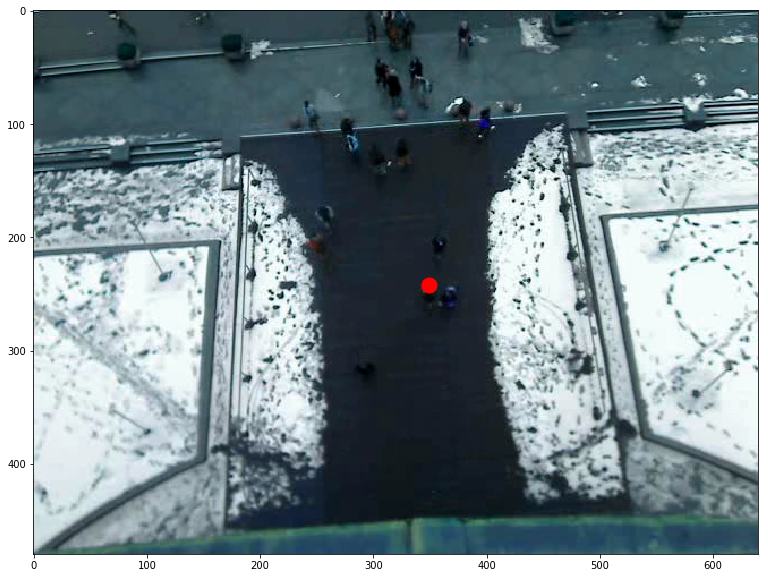

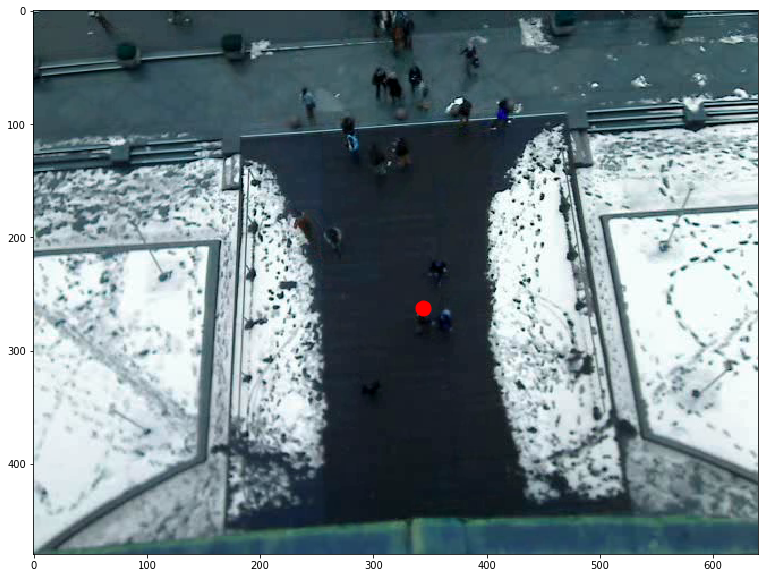

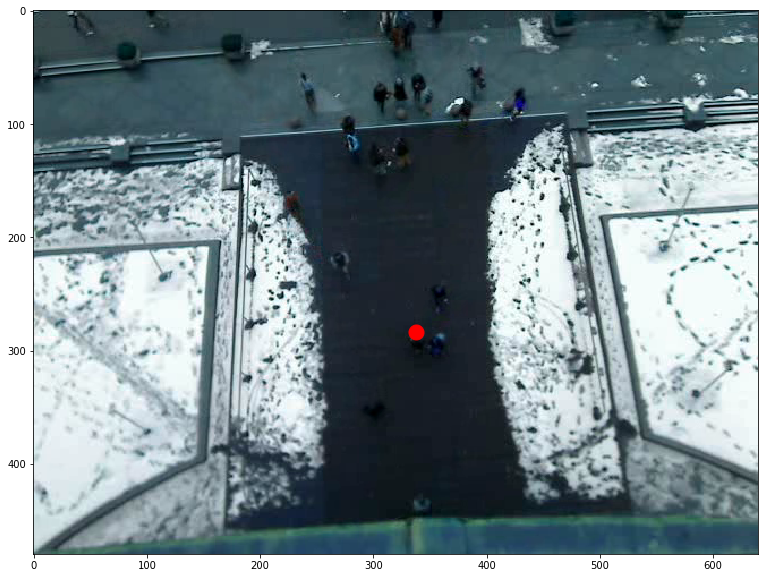

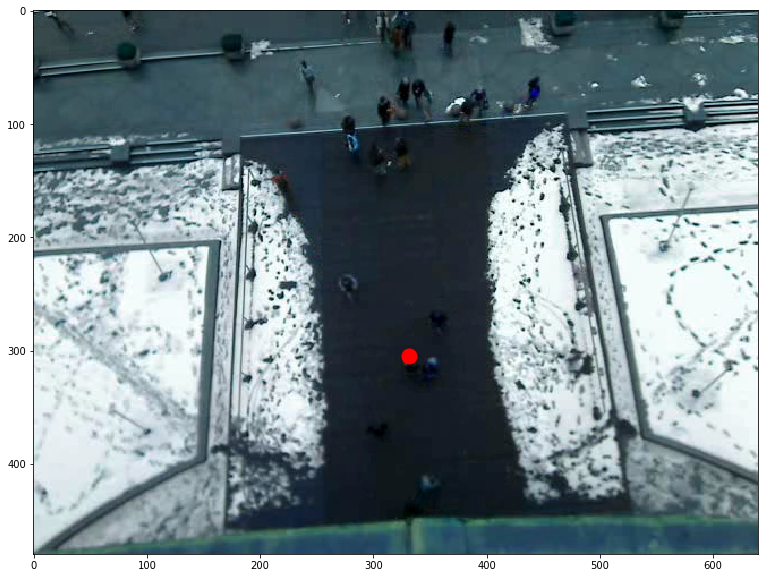

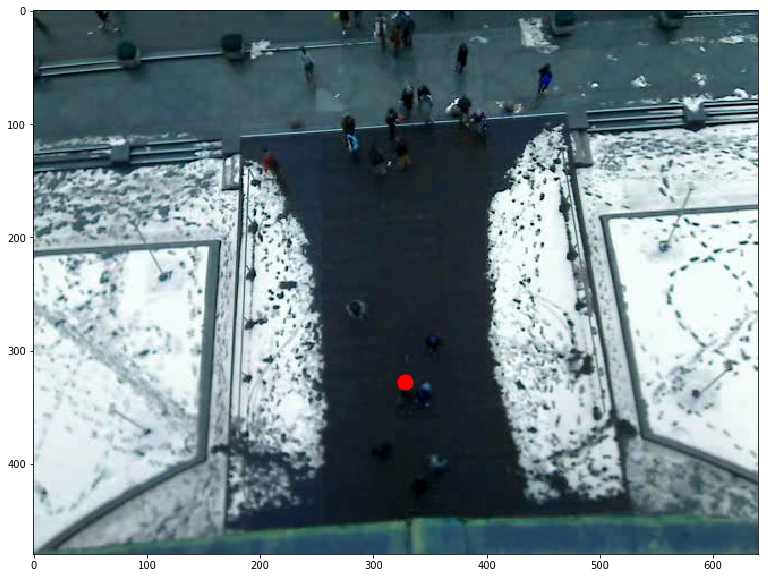

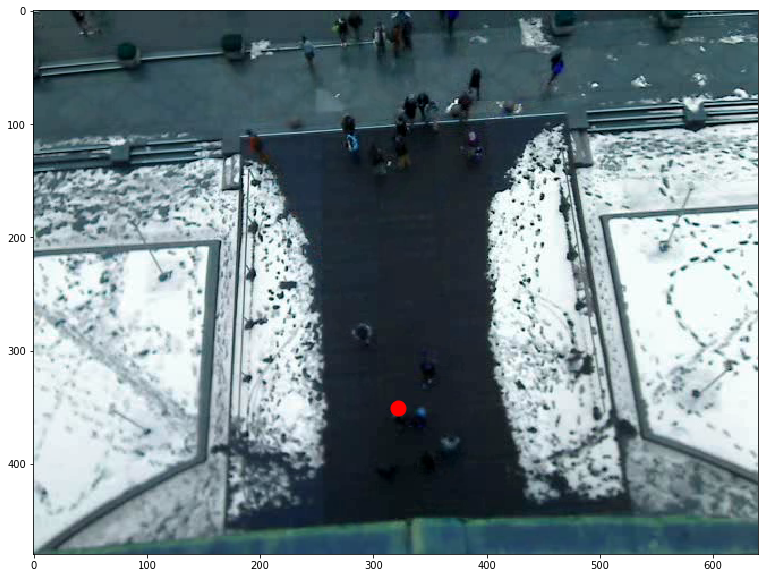

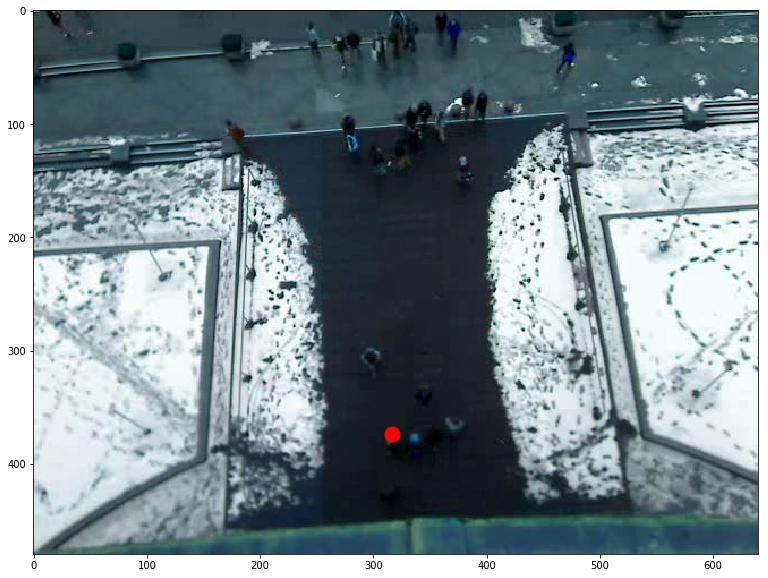

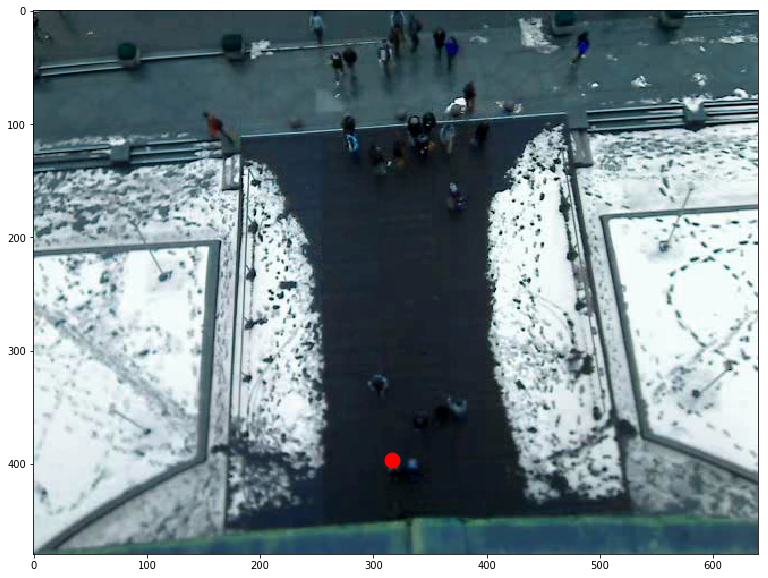

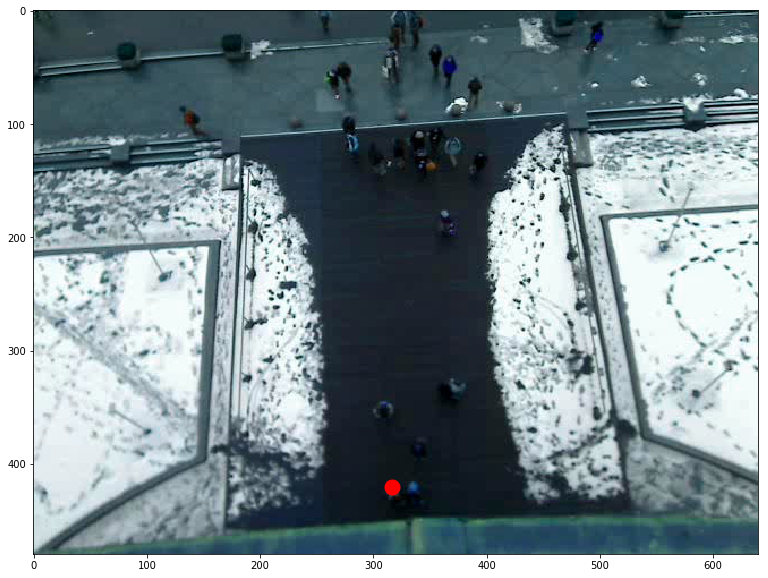

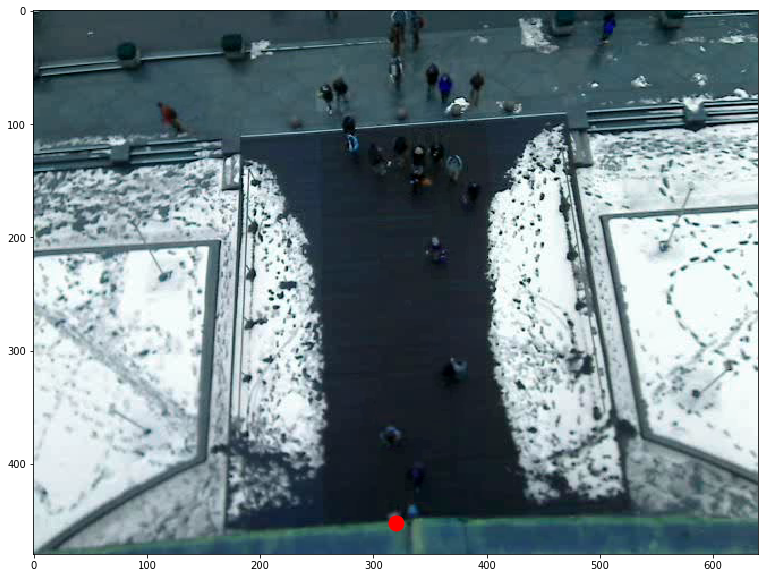

In [88]:
for t in traj[np.where(traj[:, 1]==300)]:
    frame, aid, x, y = t
    fig, ax = plt.subplots(1, 1, figsize = [20, 10])
    ax.imshow(V.getFrame(frame))
    ax.plot(*V.camcoordinates(np.array([x, y])), 'r.', markersize = 30)
    plt.show()

In [70]:
transform = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor()])

In [71]:
img = transform(Image.fromarray(x))

In [79]:
def reassign_layers(model, last_function = ['ReLU', 'Sigmoid']):
    """Takes each module in a model and restructures the functions into modules
    called layer[i] according to the position i of a function specified in 
    last_function. E.g. one would like to have layers always end with an
    activation function, then last_function should be filled with all names of
    activation functions in the model.
   
    Args:
        model (torch.nn.Module): The model that needs to be restructured.
        last_function (list of str): Function names that are used to identify 
            the end of a layer.
    """
    Concat(model)
    module = model._modules.pop('concatenated')
    functions, layers = _get_functions(module, last_function) # 
    layers = _sort_layers(module, functions, layers)
    _fill_modules(model, layers)
    

class Concat():
    """Concats all modules of the model.
    
    Note: Be cautious with recursive/residual networks. Certain blocks that 
        define the layer architecture by the forward function should stay intact.
    
    Todo:
        * Test Concat Class on all pretrained Pytorch Modules, if necessary extend
        a in method _get_module.
    
    Args:
        model (torch.nn.Module): The module which submodules will
            be concatenated to a single module called concatenated.
    
    Attributes:
        model (torch.nn.Module): The module which submodules will
            be concatenated to a single module called concatenated.
        list_of_layers (list): List to temporally store the submodules of the 
            network.
    """
    def __init__(self, model):
        self.model = model
        self.list_of_layers = []
        self._get_modules(model)
        self._concat()
    
    def _get_modules(self, model):
        """Recursively puts all submodules into list_of_layers.
        Note: Submodules in residual/recursive networks should not be split!"""
        from sys import modules
        from inspect import getmembers, isclass
        #enable for resnet, tricky: shallow and nested nn modules / keep BasicBlocks
        a = [x[1] for x in getmembers(modules[models.resnet.__name__], isclass)]
        for module in model.children():
            if not list(module.children()) or isinstance(module, tuple(a)):
                self.list_of_layers.append(module)
            else:
                self._get_modules(module)
        
    def _concat(self):
        modules = [module for module in self.model._modules]
        for module in modules:
            self.model._modules.pop(module)
        self.model._modules['concatenated'] = nn.Sequential(*self.list_of_layers)


def _get_functions(module, last_function):
    """Identifies the positions i of the functions, specified in last_function,
    and thus defining the end of the new layers.
   
    Args:
        model (torch.nn.Module): The model that needs to be restructured.
        last_function (list of str): Function names that are used to identify 
            the end of a layer.
    
    Returns:
        functions (list): A list containing the keys of all functions that were
            identified in the submodule.
        layers (dict): A dict containing a key, value pair of a layer index and
            an empty list.
    """
    functions = []
    layers = {}
    lastsubmodule = False
    for key, submodule in module._modules.items():
        if key == next(reversed(module._modules)):
            lastsubmodule = True
        match = [function in submodule.__str__() for function in last_function]
        if any(match+[lastsubmodule]):
            functions.append(key)
    layers.update({i+1:[] for i in range(len(functions))})
    return functions, layers


def _sort_layers(module, functions, layers):
    """Constructs the new layers. The modules are filled into the lists that
    describe the new layers in ascending order up to the final function. 
   
    Args:
        model (torch.nn.Module): The model that needs to be restructured.
        functions (list): A list containing the keys of all functions that were
            identified in the submodule.
        layers (dict): A dict containing a key, value pair of a layer index and
            an empty list.
    
    Returns:
        layers (dict): A dict containing a key, value pair of a layer index and 
            a list with all respective torch.nn.functions.
    """
    for i, key in enumerate(functions):
        for j in range(int(key)+1):
            try:
                layers[i+1].append(module._modules.pop(str(j)))                
            except:
                pass
    return layers


def _fill_modules(model, layers):
    """Creates the new nn.modules according to the extracted layers and assigns
    them to the model. 
   
    Args:
        model (torch.nn.Module): The model that needs to be restructured.
        layers (dict): A dict containing a key, value pair of a layer index and 
            a list with all respective torch.nn.functions.
    """
    for key, value in layers.items():
        model._modules['layer%s'%(key)] = nn.Sequential(*value)
        
def _forward(self, x):
    """A generic forward function, which stores the activations specified in 
    extracted_layers. It works for pure forward networks including transitions
    of convolution and fully connected layers. 
    
    Note: Tested with AlexNet, VGG. ResNet with its BasicBlocks kept intact.
    """
    outputs = {}
    for name, module in self._modules.items():
        for subname, submodule in module._modules.items():
            try:
                x = submodule(x)
            except:
                x = x.view(x.size(0), -1)
                x = submodule(x)
        if self.extract_layers and name in self.extract_layers:
            outputs[name] = x
            if name == self.extract_layers[-1]:
                return outputs
    if outputs:
        return outputs
    return x    

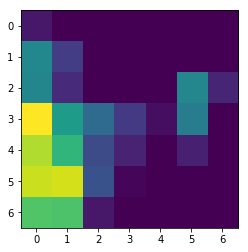

In [86]:
resnet = models.resnet18(pretrained = True)
reassign_layers(resnet)
resnet.forward = _forward.__get__(resnet, resnet.__class__)
resnet.extract_layers = ['layer9']
feat_resnet = resnet(img.unsqueeze(0))['layer9'].squeeze().data.numpy()
plt.imshow(feat_resnet[50])

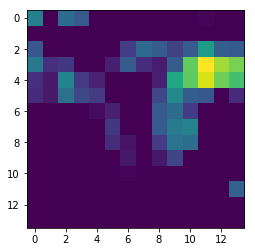

In [87]:
vgg = models.vgg16(pretrained = True)
reassign_layers(vgg)
vgg.forward = _forward.__get__(vgg, vgg.__class__)
vgg.extract_layers = ['layer13']
feat_vgg = vgg(img.unsqueeze(0))['layer13'].squeeze().data.numpy()
plt.imshow(feat_vgg[50])